In [4]:
#Intial Data Gathering

#https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star/downloads/predicting-a-pulsar-star.zip
#Only need to run once
'''
import types
import pandas as pd
from ibm_botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_14b089f539c34ef2bd724ca34f80800c = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ceCGUU9f4vIlgmKEOD598ibWqyUPtWUYBB2R_iQYiYMu',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_14b089f539c34ef2bd724ca34f80800c.get_object(Bucket='assignment11-donotdelete-pr-qgcqugb3e2w9dp', Key='predicting-a-pulsar-star.zip')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 

from io import BytesIO
import zipfile

zip_ref = zipfile.ZipFile(BytesIO(streaming_body_1.read()), 'r')
#print zip_ref.namelist()
zip_ref.extractall()
zip_ref.close()
!ls
'''



logs  pulsar_stars.csv	spark-events  user-libs


In [5]:
#Imports
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

In [6]:
#Read CSV data into a spark Data Frame
#pulsar_stars.csv
df = spark.read.format("csv").option("header", "true").load("pulsar_stars.csv")

In [7]:
#Rename Columns so easier later on, using \ to continue on new line
df = df.withColumnRenamed(" Mean of the integrated profile", "Mean_IP").withColumnRenamed(" Standard deviation of the integrated profile", "STD_IP")\
    .withColumnRenamed(" Excess kurtosis of the integrated profile", "ExcessKurtosis_IP").withColumnRenamed(" Skewness of the integrated profile", "Skewness_IP")\
    .withColumnRenamed(" Mean of the DM-SNR curve", "MeanDM-SNR_Curve").withColumnRenamed(" Standard deviation of the DM-SNR curve", "STD-DM-SNR_Curve")\
    .withColumnRenamed(" Excess kurtosis of the DM-SNR curve", "ExcessKurtosisDM-SNR_Curve").withColumnRenamed(" Skewness of the DM-SNR curve", "SkewnessDM-SNR_Curve")

In [8]:
#Change columns to double type
df = df.withColumn("Mean_IP", df["Mean_IP"].cast(DoubleType())).withColumn("STD_IP", df["STD_IP"].cast(DoubleType()))\
    .withColumn("ExcessKurtosis_IP", df["ExcessKurtosis_IP"].cast(DoubleType())).withColumn("Skewness_IP", df["Skewness_IP"].cast(DoubleType()))\
    .withColumn("MeanDM-SNR_Curve", df["MeanDM-SNR_Curve"].cast(DoubleType())).withColumn("STD-DM-SNR_Curve", df["STD-DM-SNR_Curve"].cast(DoubleType()))\
    .withColumn("ExcessKurtosisDM-SNR_Curve", df["ExcessKurtosisDM-SNR_Curve"].cast(DoubleType())).withColumn("SkewnessDM-SNR_Curve", df["SkewnessDM-SNR_Curve"].cast(DoubleType()))\
    .withColumn("target_class", df["target_class"].cast(IntegerType()))

In [9]:
#Convert to panads for future use
dfPandas = df.toPandas()
dfPandas

,Mean_IP,STD_IP,ExcessKurtosis_IP,Skewness_IP,MeanDM-SNR_Curve,STD-DM-SNR_Curve,ExcessKurtosisDM-SNR_Curve,SkewnessDM-SNR_Curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
5,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0
6,119.484375,48.765059,0.031460,-0.112168,0.999164,9.279612,19.206230,479.756567,0
7,130.382812,39.844056,-0.158323,0.389540,1.220736,14.378941,13.539456,198.236457,0
8,107.250000,52.627078,0.452688,0.170347,2.331940,14.486853,9.001004,107.972506,0
9,107.257812,39.496488,0.465882,1.162877,4.079431,24.980418,7.397080,57.784738,0


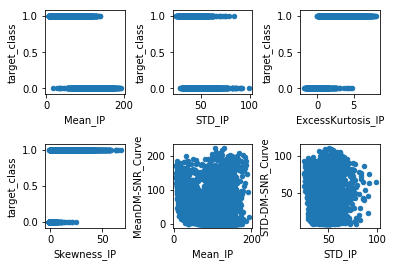

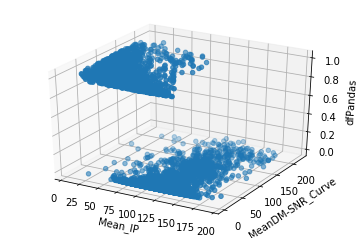

In [10]:
#Exploratory 

fig, axes = plt.subplots(nrows=2, ncols=3)
plt.subplots_adjust(wspace=0.6,hspace=0.6)

dfPandas.plot.scatter(x="Mean_IP", y ="target_class",ax=axes[0,0])
dfPandas.plot.scatter(x="STD_IP", y ="target_class",ax=axes[0,1])
dfPandas.plot.scatter(x="ExcessKurtosis_IP", y ="target_class",ax=axes[0,2])
dfPandas.plot.scatter(x="Skewness_IP", y ="target_class",ax=axes[1,0])
dfPandas.plot.scatter(x="Mean_IP", y ="MeanDM-SNR_Curve",ax=axes[1,1])
dfPandas.plot.scatter(x="STD_IP", y ="STD-DM-SNR_Curve",ax=axes[1,2])

#dfPandas.plot.scatter(x="Mean_IP",y="MeanDM-SNR_Curve", z ="target_class")
MeanIPSNR_graph = plt.figure().gca(projection='3d')
MeanIPSNR_graph.scatter(dfPandas['Mean_IP'], dfPandas['MeanDM-SNR_Curve'], dfPandas['target_class'])
MeanIPSNR_graph.set_xlabel('Mean_IP')
MeanIPSNR_graph.set_ylabel('MeanDM-SNR_Curve')
MeanIPSNR_graph.set_zlabel('dfPandas')
plt.show()





In [11]:
#Get stats about panads df
dfPandas.describe()


,Mean_IP,STD_IP,ExcessKurtosis_IP,Skewness_IP,MeanDM-SNR_Curve,STD-DM-SNR_Curve,ExcessKurtosisDM-SNR_Curve,SkewnessDM-SNR_Curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


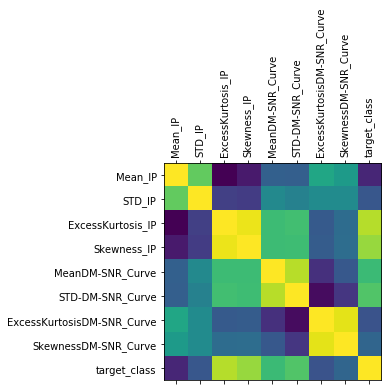

In [12]:
#Correlation Matrix of data
alpha = list(dfPandas)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dfPandas.corr())

ax.set_xticklabels(['']+alpha,rotation='vertical')
ax.set_yticklabels(['']+alpha)

plt.show()

In [15]:
#Check if null values exist in df
dfPandas.isnull().values.any()

#print how many in class 1 vs class 0
dfPandas['target_class'].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

In [17]:
#Create a feature vector for ML Model
vectorAssembler = VectorAssembler(inputCols=["Mean_IP","STD_IP","ExcessKurtosis_IP","Skewness_IP","MeanDM-SNR_Curve","STD-DM-SNR_Curve","ExcessKurtosisDM-SNR_Curve","SkewnessDM-SNR_Curve"], outputCol="features")

#Normalize the feature so large value ranges won't effect model
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

#Using LogisticRegression a baseline model
lr = LogisticRegression(maxIter=10,labelCol='target_class')

#Use sparkml's pipeline to feature to combine above code
pipeline = Pipeline(stages=[vectorAssembler,normalizer,lr])


In [18]:
#Split the data into train and test set. SHOULD IMPLENENT CROSS FOLD VALIDATION LATER
train_df, test_df= df.randomSplit([0.8, 0.2])

#Check to make sure train and test data added together still conatians all the data
df.count() == train_df.count()+test_df.count()


#Create X and Y for train and test (Used in TF NN)
feature_names = list(dfPandas)[:-1]
target_name = list(dfPandas)[-1]
x_train = np.array(train_df.select(feature_names).collect())
y_train = np.array(train_df.select(target_name).collect())
x_test = np.array(test_df.select(feature_names).collect())
y_test = np.array(test_df.select(target_name).collect())

In [19]:
#Train the model
model = pipeline.fit(train_df)

In [20]:



#TRAINING Stats
print ("\n\n-------------------Train Set Stats ----------------")
predictions = model.transform(train_df)

# Select (prediction, true label) and compute test accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="target_class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Train accuracy = %g " % (accuracy))

#F1 for test
evaluator = MulticlassClassificationEvaluator( labelCol="target_class", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
print("Train F1 Score = %g " % (accuracy))

#Precision for test
evaluator = MulticlassClassificationEvaluator( labelCol="target_class", predictionCol="prediction", metricName="weightedPrecision")
accuracy = evaluator.evaluate(predictions)
print("Train Precision = %g " % (accuracy))

#Recall for test
evaluator = MulticlassClassificationEvaluator( labelCol="target_class", predictionCol="prediction", metricName="weightedRecall")
accuracy = evaluator.evaluate(predictions)
print("Train Recall = %g " % (accuracy))



#TESTING Stats
print ("\n\n-------------------Test Set Stats ----------------")
# Make predictions.
predictions = model.transform(test_df)

# Select (prediction, true label) and compute test accuracy
evaluator = MulticlassClassificationEvaluator( labelCol="target_class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test accuracy = %g " % (accuracy))

#F1 for test
evaluator = MulticlassClassificationEvaluator( labelCol="target_class", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
print("Test F1 Score = %g " % (accuracy))

#Precision for test
evaluator = MulticlassClassificationEvaluator( labelCol="target_class", predictionCol="prediction", metricName="weightedPrecision")
accuracy = evaluator.evaluate(predictions)
print("Test Precision = %g " % (accuracy))

#Recall for test
evaluator = MulticlassClassificationEvaluator( labelCol="target_class", predictionCol="prediction", metricName="weightedRecall")
accuracy = evaluator.evaluate(predictions)
print("Test Recall = %g " % (accuracy))





-------------------Train Set Stats ----------------
Train accuracy = 0.973202 
Train F1 Score = 0.971903 
Train Precision = 0.972542 
Train Recall = 0.973202 


-------------------Test Set Stats ----------------
Test accuracy = 0.98142 
Test F1 Score = 0.980672 
Test Precision = 0.981308 
Test Recall = 0.98142 


In [79]:
#Building a different model - Deep Learning Model

model = Sequential()  # Instantiate sequential model
model.add(Dense(units=512,input_shape=(len(feature_names),),activation="relu")) # Add first layer. Make sure to specify input shape
model.add(Dropout(0.5)) # Add second layer
model.add(Dense(units=50,activation="sigmoid")) # Add third layer
model.add(Dropout(0.5)) # Add forth layer
model.add(Dense(units=1,activation="sigmoid")) # Add fifth layer
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               4608      
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 50)                25650     
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 51        
Total params: 30,309
Trainable params: 30,309
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
#To Prevent Errors in Watson Studio due to limited resourses 
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

In [85]:
#Run mini batch for 15 epochs

batch_size_var = 50
model.fit(x_train,y_train,epochs=15,batch_size=batch_size_var)
score = model.evaluate(x_test,y_test,batch_size=batch_size_var)



Epoch 1/15
14292/14292 [==============================] - 1s 67us/step - loss: 0.0964 - acc: 0.9732
Epoch 2/15
14292/14292 [==============================] - 1s 61us/step - loss: 0.1000 - acc: 0.9710
Epoch 3/15
14292/14292 [==============================] - 1s 62us/step - loss: 0.0990 - acc: 0.9730
Epoch 4/15
14292/14292 [==============================] - 1s 63us/step - loss: 0.0991 - acc: 0.9719
Epoch 5/15
14292/14292 [==============================] - 1s 63us/step - loss: 0.0973 - acc: 0.9729
Epoch 6/15
14292/14292 [==============================] - 1s 63us/step - loss: 0.0999 - acc: 0.9731
Epoch 7/15
14292/14292 [==============================] - 1s 62us/step - loss: 0.0971 - acc: 0.9726
Epoch 8/15
14292/14292 [==============================] - 1s 62us/step - loss: 0.0969 - acc: 0.9731
Epoch 9/15
14292/14292 [==============================] - 1s 64us/step - loss: 0.0991 - acc: 0.9722
Epoch 10/15
14292/14292 [==============================] - 1s 64us/step - loss: 0.0979 - acc: 0.9725